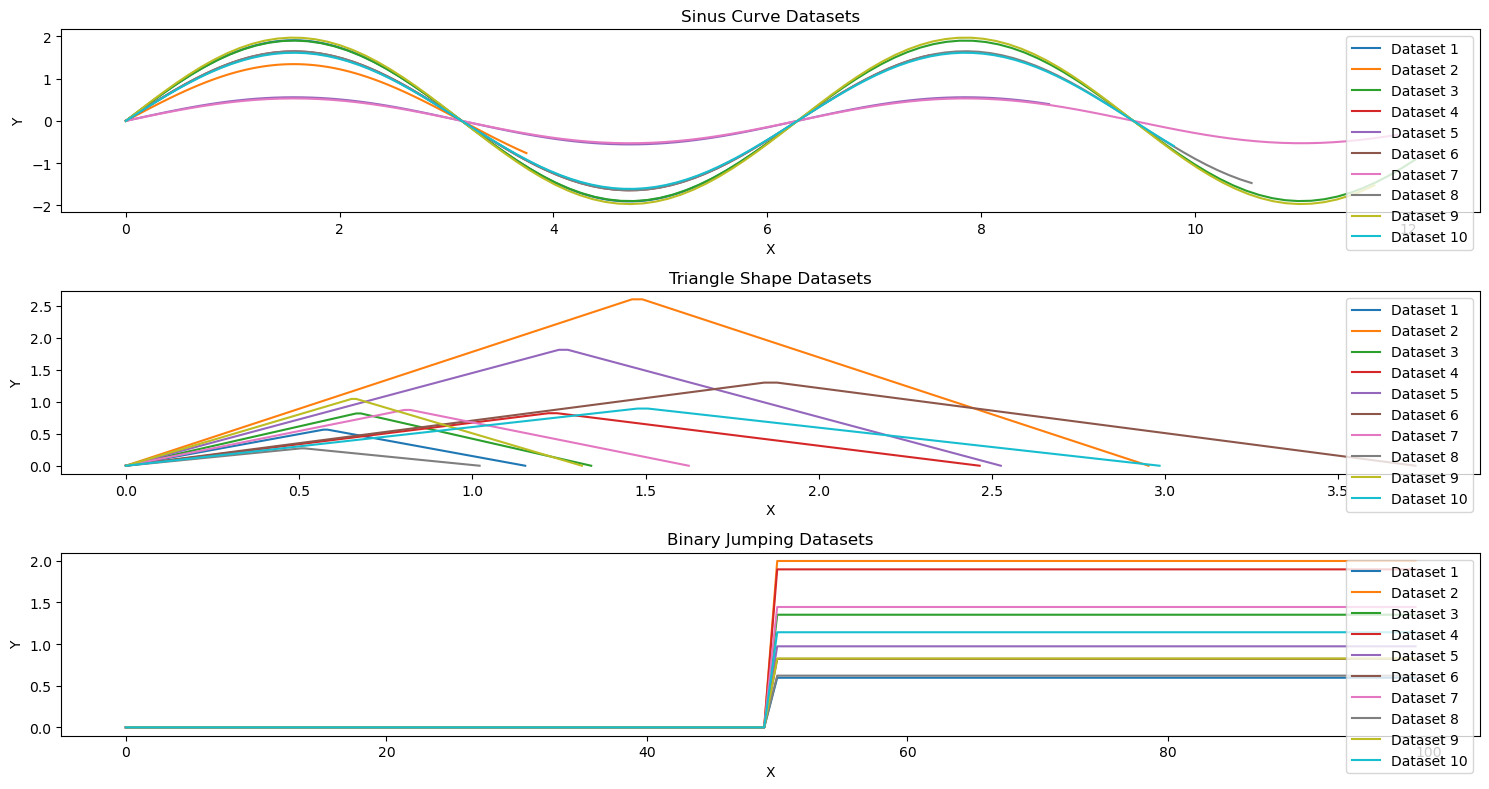

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate sinus curve dataset with varying length and amplitude
def generate_sin_dataset(size, length_factor, amplitude_factor):
    x = np.linspace(0, 2 * np.pi * length_factor, size)
    y = amplitude_factor * np.sin(x)
    return x, y

# Function to generate triangle-shaped dataset with varying length and amplitude
def generate_triangle_dataset(size, length_factor, amplitude_factor):
    x = np.linspace(0, 2 * length_factor, size)
    y = amplitude_factor * np.piecewise(x, [x < length_factor, x >= length_factor], [lambda x: x, lambda x: 2 * length_factor - x])
    return x, y

# Function to generate binary jumping dataset with varying length and amplitude
def generate_binary_jump_dataset(size, length_factor, amplitude_factor, jump_interval=50):
    x = np.arange(size)
    y = amplitude_factor * np.concatenate([np.zeros(jump_interval), np.ones(jump_interval)])
    num_repeats = size // (2 * jump_interval)
    y = np.tile(y, num_repeats)[:size]
    return x, y

# Plotting each class in a separate plot
num_datasets = 10

plt.figure(figsize=(15, 8))

# Plot Sinus Curve datasets
plt.subplot(3, 1, 1)
plt.title('Sinus Curve Datasets')
plt.xlabel('X')
plt.ylabel('Y')
for i in range(num_datasets):
    length_factor = np.random.uniform(0.5, 2.0)
    amplitude_factor = np.random.uniform(0.5, 2.0)
    sin_x, sin_y = generate_sin_dataset(100, length_factor, amplitude_factor)
    plt.plot(sin_x, sin_y, label=f'Dataset {i+1}')
plt.legend()

# Plot Triangle Shape datasets
plt.subplot(3, 1, 2)
plt.title('Triangle Shape Datasets')
plt.xlabel('X')
plt.ylabel('Y')
for i in range(num_datasets):
    length_factor = np.random.uniform(0.5, 2.0)
    amplitude_factor = np.random.uniform(0.5, 2.0)
    triangle_x, triangle_y = generate_triangle_dataset(100, length_factor, amplitude_factor)
    plt.plot(triangle_x, triangle_y, label=f'Dataset {i+1}')
plt.legend()

# Plot Binary Jumping datasets
plt.subplot(3, 1, 3)
plt.title('Binary Jumping Datasets')
plt.xlabel('X')
plt.ylabel('Y')
for i in range(num_datasets):
    length_factor = np.random.uniform(0.5, 2.0)
    amplitude_factor = np.random.uniform(0.5, 2.0)
    binary_jump_x, binary_jump_y = generate_binary_jump_dataset(100, length_factor, amplitude_factor)
    plt.plot(binary_jump_x, binary_jump_y, label=f'Dataset {i+1}')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tcn import TCN
from tensorflow.keras.layers import Masking



def generate_sin_dataset(size, length_factor, amplitude_factor):
    x = np.linspace(0, 2 * np.pi * length_factor, size)
    y = amplitude_factor * np.sin(x)
    label = 1  # Assign label for sinus curve
    return x, y, label

def generate_triangle_dataset(size, length_factor, amplitude_factor):
    x = np.linspace(0, 2 * length_factor, size)
    y = amplitude_factor * np.piecewise(x, [x < length_factor, x >= length_factor], [lambda x: x, lambda x: 2 * length_factor - x])
    label = 2  # Assign label for triangle shape
    return x, y, label

def generate_binary_jump_dataset(size, length_factor, amplitude_factor, jump_interval=50):
    # Ensure that size is greater than or equal to jump_interval
    size = max(size, jump_interval)
    
    x = np.arange(size)
    x = x/ np.random.uniform(8, 16)
    y = amplitude_factor * np.concatenate([np.zeros(jump_interval), np.ones(jump_interval)])
    y = y + np.random.normal(0, 0.1, size=y.shape)
    num_repeats = size // (2 * jump_interval)
    y = np.tile(y, num_repeats)[:size]
    label = 0  # Assign label for binary jumping
    return x, y, label

def generate_sequence_data(num_samples, max_sequence_length, num_classes):
    X = []
    y = []
    yaxes = []
    xaxes = []

    for _ in range(num_samples):
        # Randomly choose a dataset function
        dataset_function = np.random.choice([generate_sin_dataset, generate_triangle_dataset, generate_binary_jump_dataset])

        length_factor = np.random.uniform(0.5, 2.0)
        amplitude_factor = np.random.uniform(0.5, 2.0)
        
        # Ensure that sequence_length is at least jump_interval
        jump_interval=20
        sequence_length = np.random.randint(2 * jump_interval, max_sequence_length + 1)
        
        x_sequence, y_sequence, label = dataset_function(sequence_length, length_factor, amplitude_factor)

        noise = np.random.normal(0, 0.05, size=y_sequence.shape)
        y_sequence=y_sequence+noise

        X.append(y_sequence)  # Do not reshape here
        y.append(label)
        yaxes.append(y_sequence)
        xaxes.append(x_sequence)

    # Pad sequences to a common length
    X_padded = pad_sequences(X, padding='post', dtype='float32')

    y = np.array(y)

    return X_padded, y, yaxes, xaxes


# Hyperparameters
num_samples = 1000
max_sequence_length = 200  # Maximum sequence length
num_classes = 3
batch_size = 32
epochs = 3

# Generate synthetic sequential data with varying lengths
X, y ,yax, xax= generate_sequence_data(num_samples, max_sequence_length, num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Build TCN model with variable sequence length
"""model = Sequential([
    TCN(input_shape=(None, 1)),  # Allow variable sequence length
    Dense(num_classes, activation='softmax')
])"""

# Modify your model to include a Masking layer
model = Sequential([
    Masking(mask_value=0.0, input_shape=(None, 1)),  # Assuming your input is 1-dimensional
    TCN(input_shape=(None, 1)),  # Allow variable sequence length
    Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [3]:
# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# model.save('tcn_model_2d_noise.h5')

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Test Accuracy: {accuracy}")

Epoch 1/3
13/13 [==============================] - 5s 46ms/step - loss: 0.8830 - accuracy: 0.8350 - val_loss: 0.2172 - val_accuracy: 0.9700
Epoch 2/3
13/13 [==============================] - 0s 14ms/step - loss: 0.2128 - accuracy: 0.9775 - val_loss: 0.1774 - val_accuracy: 0.9700
Epoch 3/3
16/16 [==============================] - 0s 6ms/step - loss: 0.1147 - accuracy: 0.9800
Test Accuracy: 0.9800000190734863


In [4]:
import plotly.express as px
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tcn import TCN
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


def generate_sin_dataset(size, length_factor, amplitude_factor):
    x = np.linspace(0, 2 * np.pi * length_factor, size)
    y = amplitude_factor * np.sin(x)
    label = 1  # Assign label for sinus curve
    return x, y, label

def generate_triangle_dataset(size, length_factor, amplitude_factor):
    x = np.linspace(0, 2 * length_factor, size)
    y = amplitude_factor * np.piecewise(x, [x < length_factor, x >= length_factor], [lambda x: x, lambda x: 2 * length_factor - x])
    label = 2  # Assign label for triangle shape
    return x, y, label

def generate_binary_jump_dataset(size, length_factor, amplitude_factor, jump_interval=50):
    # Ensure that size is greater than or equal to jump_interval
    size = max(size, jump_interval)
    
    x = np.arange(size)
    x = x / np.random.uniform(8, 16)
    y = amplitude_factor * np.concatenate([np.zeros(jump_interval), np.ones(jump_interval)])
    y = y + np.random.normal(0, 0.1, size=y.shape)
    num_repeats = size // (2 * jump_interval)
    y = np.tile(y, num_repeats)[:size]
    label = 0  # Assign label for binary jumping
    return x, y, label

def generate_sequence_data(num_samples, max_sequence_length, num_classes):
    X = []
    y = []
    yaxes = []
    xaxes = []

    for _ in range(num_samples):
        # Randomly choose a dataset function
        dataset_function = np.random.choice([generate_sin_dataset, generate_triangle_dataset, generate_binary_jump_dataset])

        length_factor = np.random.uniform(0.5, 2.0)
        amplitude_factor = np.random.uniform(0.5, 2.0)
        jump_interval = 50

        # Randomly choose the sequence length for each sample
        sequence_length = np.random.randint(2 * jump_interval, max_sequence_length + 1)

        x_sequence, y_sequence, label = dataset_function(sequence_length, length_factor, amplitude_factor)

        noise = np.random.normal(0, 0.05, size=y_sequence.shape)
        y_sequence = y_sequence + noise

        X.append(y_sequence)
        y.append(label)
        min_length = min(len(x_sequence), len(y_sequence))
        x_sequence = x_sequence[:min_length]
        y_sequence = y_sequence[:min_length]

        xaxes.append(x_sequence)
        yaxes.append(y_sequence)

    # Pad sequences to the maximum length in X
    X_padded = pad_sequences(X, padding='post', dtype='float32')
    

    y = np.array(y)

    return X_padded, y, yaxes, xaxes




# Load the saved model
loaded_model = load_model('tcn_model_2d_noise.h5', custom_objects={'TCN': TCN})

num_samples = 20
num_classes = 3
max_sequence_length = 200  # You need to define the maximum sequence length here


# Generate synthetic sequential test data
X_test, y_test, yaxes, xaxes = generate_sequence_data(num_samples//2, max_sequence_length, num_classes)


# Predict labels for test data
y_pred = loaded_model.predict(X_test)
predicted_labels = np.argmax(y_pred, axis=1)

import pandas as pd

print(len(X_test))

# Create separate plots for each test sequence using Plotly Express
for i in range(len(X_test)):
    #sequence_length = len(X_test[i].nonzero()[0])
    #x_values = np.linspace(0, 2 * np.pi * length_factor, sequence_length)
    
    print(f"Length of 'Y': {len(yaxes[i])}")
    print(f"Length of 'X': {len(xaxes[i])}")
    
    df = pd.DataFrame({'Y': yaxes[i], 'X-axis': xaxes[i]})
    
    fig = px.line(df, x='X-axis', y='Y', title=f'Test Sequence {i+1} | True Label: {y_test[i]}, Predicted Label: {predicted_labels[i]}')
    fig.update_layout(xaxis_title="X", yaxis_title="Y")
    fig.show()




1/1 [==============================] - 0s 285ms/step
10
Length of 'Y': 116
Length of 'X': 116


Length of 'Y': 155
Length of 'X': 155


Length of 'Y': 100
Length of 'X': 100


Length of 'Y': 149
Length of 'X': 149


Length of 'Y': 162
Length of 'X': 162


Length of 'Y': 114
Length of 'X': 114


Length of 'Y': 100
Length of 'X': 100


Length of 'Y': 176
Length of 'X': 176


Length of 'Y': 100
Length of 'X': 100


Length of 'Y': 148
Length of 'X': 148
